In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from geotext import GeoText
import gensim
import os
import re
pwd = os.getcwd()

In [2]:
df = pd.read_csv(os.path.basename(pwd+'/Eluvio_DS_Challenge.csv'))

In [3]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [4]:
df.author.value_counts()[:10]

davidreiss666    8897
anutensil        5730
DoremusJessup    5037
maxwellhill      4023
igeldard         4013
readerseven      3170
twolf1           2923
madam1           2658
nimobo           2564
madazzahatter    2503
Name: author, dtype: int64

In [5]:
print(df.category.value_counts())
print(df.down_votes.value_counts())

worldnews    509236
Name: category, dtype: int64
0    509236
Name: down_votes, dtype: int64


### Category is worldnews and down_votes is zero for all the columns, we can remove these 2 column as these will have no statistical significance

In [6]:
df.drop(['category','down_votes'], axis=1, inplace=True)

In [7]:
df["Month"] = list(map(lambda x: datetime.strptime(x,'%Y-%m-%d').strftime('%B'), df['date_created']))
df["Year"]  = list(map(lambda x: datetime.strptime(x,'%Y-%m-%d').strftime('%Y'), df['date_created']))
df["day"]   = list(map(lambda x :datetime.strptime(x, '%Y-%m-%d').strftime("%A"), df['date_created']))

In [8]:
df.drop(['time_created','date_created'], axis=1, inplace=True)

In [9]:
df.head()

,up_votes,title,over_18,author,Month,Year,day
0,3,Scores killed in Pakistan clashes,False,polar,January,2008,Friday
1,2,Japan resumes refuelling mission,False,polar,January,2008,Friday
2,3,US presses Egypt on Gaza border,False,polar,January,2008,Friday
3,1,Jump-start economy: Give health care to all,False,fadi420,January,2008,Friday
4,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,January,2008,Friday


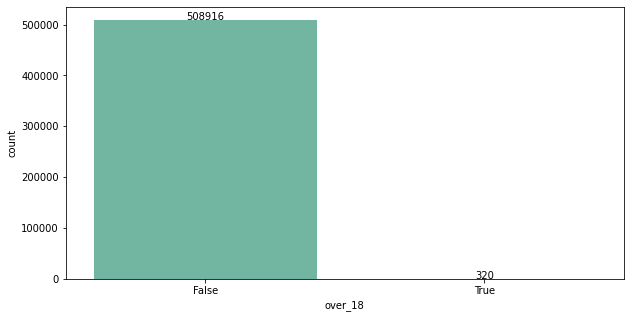

In [10]:
fig, ax1 = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax1,x='over_18', data=df,palette="Set2")
graph.set_xticklabels(graph.get_xticklabels())

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

<AxesSubplot:xlabel='Year', ylabel='avg_upvotes'>

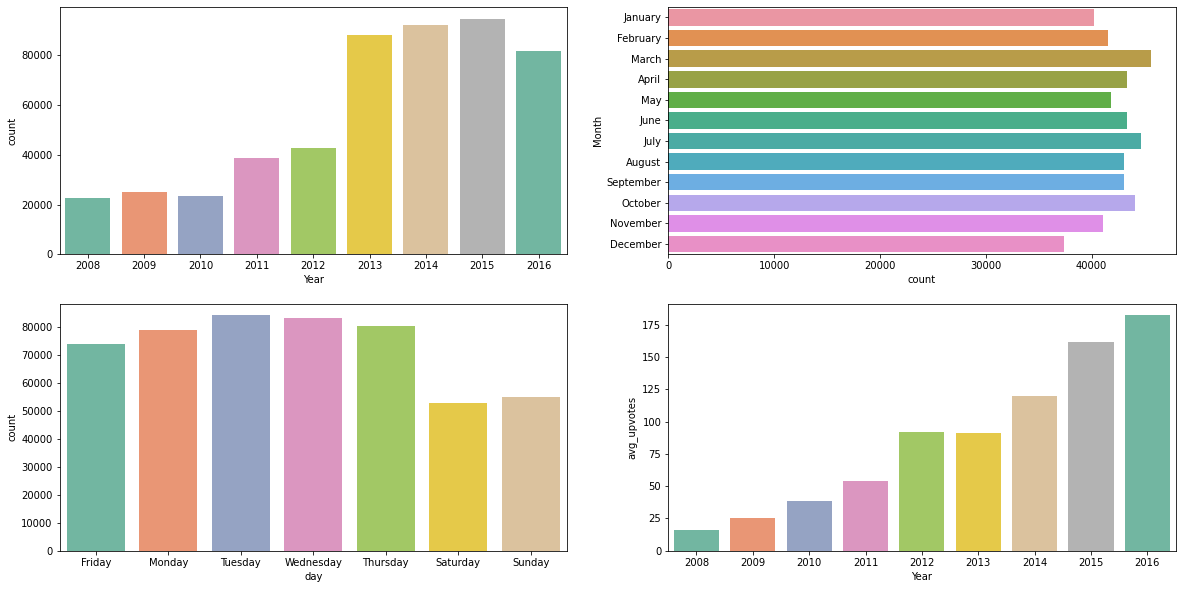

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
sns.countplot(x='Year',data=df, ax=ax[0,0],palette="Set2")
sns.countplot(y='Month',data=df, ax=ax[0,1])
sns.countplot(x='day',data=df, ax=ax[1,0],palette="Set2")

avg = df.groupby('Year').mean()['up_votes'].reset_index(name='avg_upvotes')
sns.barplot(x='Year',y='avg_upvotes',data=avg, ax=ax[1,1],palette="Set2")

In [12]:
df.sort_values(by=['up_votes'], ascending=False)[:5]

,up_votes,title,over_18,author,Month,Year,day
377200,21253,A biotech startup has managed to 3-D print fak...,False,KRISHNA53,June,2015,Saturday
391415,13435,Twitter has forced 30 websites that archive po...,False,joeyoungblood,August,2015,Monday
450818,13244,2.6 terabyte leak of Panamanian shell company ...,False,mister_geaux,April,2016,Sunday
391318,12333,The police officer who leaked the footage of t...,False,navysealassulter,August,2015,Sunday
390252,11288,Paris shooting survivor suing French media for...,False,seapiglet,August,2015,Tuesday


### Highest up_votes is 21253, I will remove that when doing the regression

## Exploratory Analysis

Wordcloud package to get a visual representation of most common words

In [13]:
from wordcloud import WordCloud
from gensim.models import KeyedVectors
# wv_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary=True)

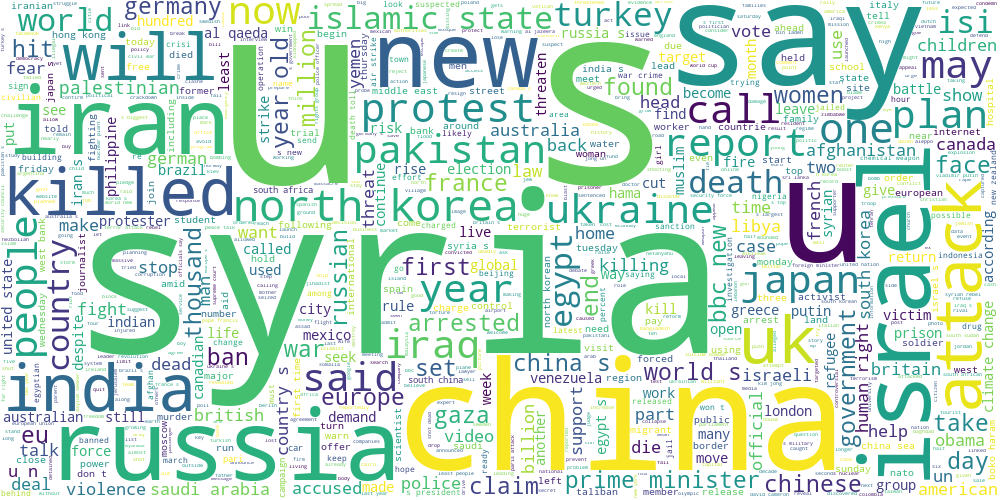

<Figure size 1080x576 with 0 Axes>

In [25]:
# Join the different processed titles together.
long_string = ','.join(list(df['title'].values))# Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5,
                      width = 1000, height = 500,contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
plt.figure(figsize=(15,8))
wordcloud.to_image()

From the WordCloud I have noticed that Title consist of so countries that's why I decided to add feature **Country**

In [15]:
def get_country(text):
    count = GeoText(text).countries
    w = ''
    if not count :
        return np.nan
    else:
        for country in count:
            w = w+' '+country
        return w    

In [16]:
df['country'] = df['title'].map(lambda com : get_country(com))

<AxesSubplot:xlabel='count', ylabel='country'>

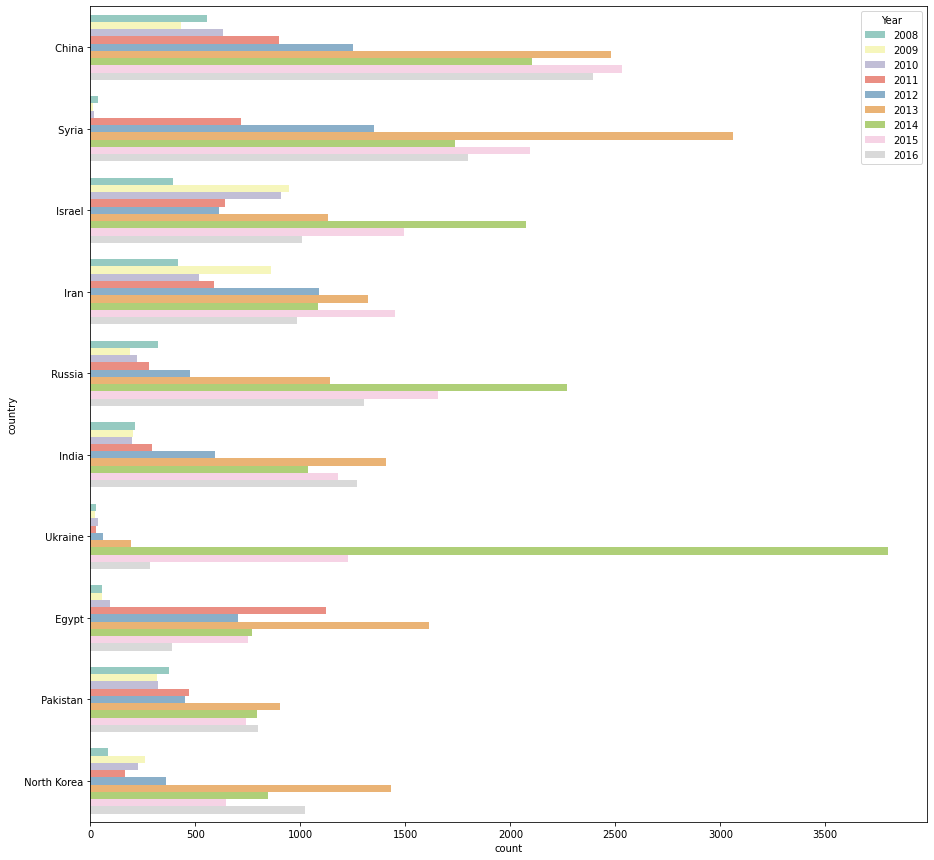

In [52]:
fig = plt.figure(figsize=(15,15))
sns.countplot(y='country',
              order = df['country'].value_counts().iloc[:10].index,data=df,
              hue=df['Year'],palette="Set3")

In [18]:
#Author

<AxesSubplot:xlabel='count', ylabel='author'>

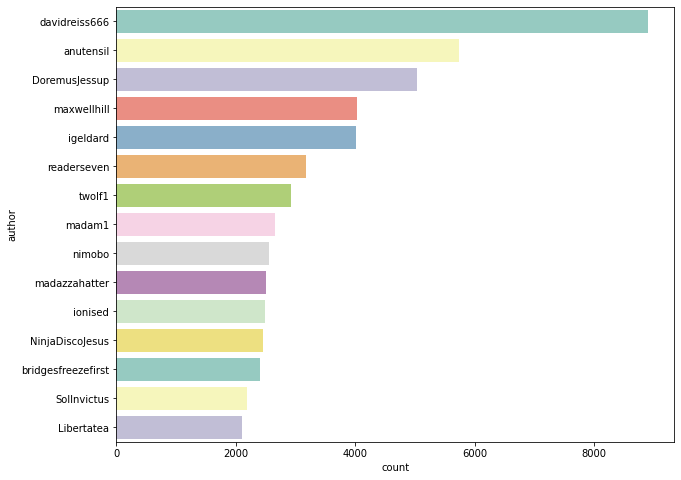

In [26]:
plt.figure(figsize=(10,8))
sns.countplot(y='author',
              order = df['author'].value_counts().iloc[:15].index,data=df,
              palette="Set3")

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [39]:
sid_obj = SentimentIntensityAnalyzer() 

rating=[]

for i in range(len(df["title"])):
    sentiment_score = sid_obj.polarity_scores(df["title"][i])
    sentiment_score = sentiment_score["compound"]
    rating.append(sentiment_score)

is_sentiment = []
for i in range(len(rating)):
    if rating[i]>0.05:
        is_sentiment.append("Positive")
    elif rating[i]<-0.05:
        is_sentiment.append("Negative")
    else:
        is_sentiment.append("Neutral")

df = df.assign(is_sentiment = is_sentiment)

In [41]:
df["is_sentiment"].value_counts()

Negative    271452
Neutral     137555
Positive    100229
Name: is_sentiment, dtype: int64

<AxesSubplot:xlabel='is_sentiment', ylabel='count'>

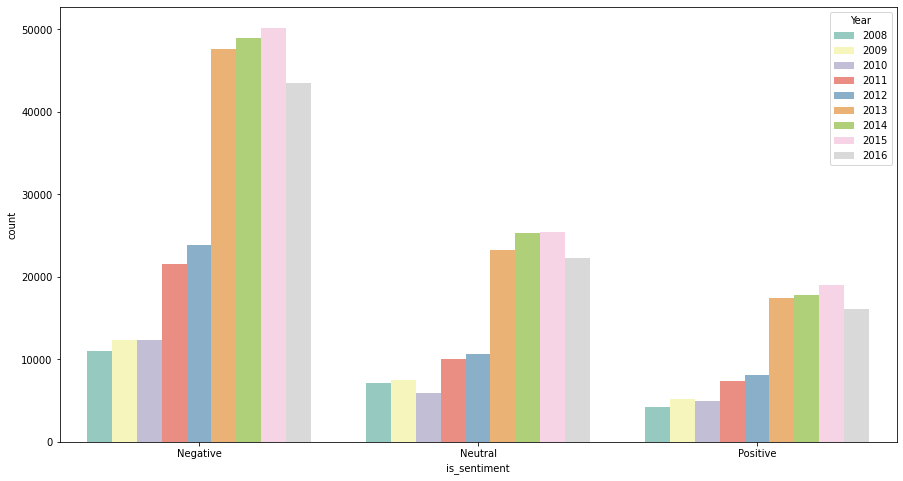

In [50]:
fig = plt.figure(figsize=(15,8))
sns.countplot(x='is_sentiment',data=df,
              hue=df['Year'],palette="Set3")

# Topic Modeling: LDA 

In [59]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize  
import gensim.corpora as corpora
from gensim import corpora, models

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [57]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r"U S", "US", text)
    text = re.sub(r"U S ", "US", text)
    text = re.sub(r"U of", "University of", text)
    text = re.sub(r"N Korea", "NorthKorea", text)
    text = re.sub(r"New York Times", "NewYorkTimes", text)
    text = re.sub(r"U N", "UN", text)
    text = re.sub(r"U N ", "UN", text)
    text = text.strip(' ')
    return text

def lemmatized(text):
    lemmatized_list = [lemmatizer.lemmatize(word) for word in text]
    return lemmatized_list

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [53]:
df['title'] = df['title'].map(lambda com : clean_text(com))

In [73]:
stopword = nltk.corpus.stopwords.words('english')
tokenized =[]
for i in range(len(df["title"])):
    filtered = []
    word_tokens = word_tokenize(df["title"][i]) 
    filtered = [j for j in word_tokens if j not in stopword]
    tokenized.append(filtered)
    
df = df.assign(tokenized = tokenized)
df["lemmatized"] = df["tokenized"].apply(lambda x: lemmatized(x))

In [74]:
df.head()

,up_votes,title,over_18,author,Month,Year,day,country,is_sentiment,tokenized,lemmatized
0,3,scores killed in pakistan clashes,False,polar,January,2008,Friday,Pakistan,Negative,"[scores, killed, pakistan, clashes]","[score, killed, pakistan, clash]"
1,2,japan resumes refuelling mission,False,polar,January,2008,Friday,Japan,Neutral,"[japan, resumes, refuelling, mission]","[japan, resume, refuelling, mission]"
2,3,us presses egypt on gaza border,False,polar,January,2008,Friday,Egypt,Neutral,"[us, presses, egypt, gaza, border]","[u, press, egypt, gaza, border]"
3,1,jump start economy give health care to all,False,fadi420,January,2008,Friday,NaN,Positive,"[jump, start, economy, give, health, care]","[jump, start, economy, give, health, care]"
4,4,council of europe bashes eu un terror blacklist,False,mhermans,January,2008,Friday,NaN,Negative,"[council, europe, bashes, eu, un, terror, blac...","[council, europe, bash, eu, un, terror, blackl..."
